In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os

In [2]:
# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

In [3]:
# Load and prepare data
data = load_iris()
X = data.data
y = data.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
X_train_t = torch.FloatTensor(X_train_scaled)
X_test_t = torch.FloatTensor(X_test_scaled)
y_train_t = torch.LongTensor(y_train)
y_test_t = torch.LongTensor(y_test)

In [7]:
class ANN(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[64, 32], num_classes=3):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def copy_weights_from(self, other_model):
        self.load_state_dict(other_model.state_dict())

In [8]:
def train_model_with_shuffled_data(model, X_train, y_train, epochs=50, batch_size=32, lr=0.001):
    # Create shuffled dataset
    shuffle_idx = torch.randperm(len(X_train))
    X_shuffled = X_train[shuffle_idx]
    y_shuffled = y_train[shuffle_idx]
    
    # Create DataLoader
    dataset = TensorDataset(X_shuffled, y_shuffled)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return model

In [9]:
# Initialize two models with IDENTICAL weights
print("Initializing models with identical weights...")
model1 = ANN()
model2 = ANN()

Initializing models with identical weights...


In [10]:
initial_weights = model1.state_dict()
torch.save(initial_weights, 'initial_weights.pth')

# Ensure model2 has exact same weights
model2.load_state_dict(initial_weights)

<All keys matched successfully>

In [11]:
for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
    assert torch.equal(param1, param2), f"Initial weights not identical for {name1}"
print("✓ Initial weights verified as identical")


✓ Initial weights verified as identical


In [12]:
print("\nTraining Model 1...")
model1 = train_model_with_shuffled_data(model1, X_train_t, y_train_t, epochs=50)

print("Training Model 2 (with different shuffling)...")
model2 = train_model_with_shuffled_data(model2, X_train_t, y_train_t, epochs=50)


Training Model 1...
Training Model 2 (with different shuffling)...


In [13]:
def get_all_activations(model, X_data):
    activations = {}
    hooks = []
    
    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    hooks.append(model.fc1.register_forward_hook(get_activation('fc1')))
    hooks.append(model.fc2.register_forward_hook(get_activation('fc2')))
    hooks.append(model.fc3.register_forward_hook(get_activation('fc3')))
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(X_data)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return activations

In [14]:
# Collect activations for both models on the SAME test data
print("\nCollecting activations from both models...")
activations1 = get_all_activations(model1, X_test_t)
activations2 = get_all_activations(model2, X_test_t)

In [15]:
def analyze_activation_differences(activations1, activations2):
    results = []
    
    layers = ['fc1', 'fc2', 'fc3']
    
    for layer in layers:
        act1 = activations1[layer]
        act2 = activations2[layer]
        
        # Calculate differences
        abs_diff = torch.abs(act1 - act2)
        
        # For each sample
        for sample_idx in range(act1.shape[0]):
            sample_diff = abs_diff[sample_idx]
            
            # For each neuron
            for neuron_idx in range(sample_diff.shape[0]):
                neuron_diff = sample_diff[neuron_idx].item()
                
                results.append({
                    'layer': layer,
                    'sample_idx': sample_idx,
                    'neuron_idx': neuron_idx,
                    'activation_model1': act1[sample_idx, neuron_idx].item(),
                    'activation_model2': act2[sample_idx, neuron_idx].item(),
                    'abs_difference': neuron_diff,
                    'relative_difference': neuron_diff / (abs(act1[sample_idx, neuron_idx].item()) + 1e-10)
                })
    
    return pd.DataFrame(results)

In [16]:
# Analyze differences
diff_df = analyze_activation_differences(activations1, activations2)
print(f"Total activation comparisons: {len(diff_df)}")

Total activation comparisons: 2970


In [17]:
# Find minimum differences per layer
print("\nMinimum absolute differences per layer:")
print("="*50)

min_diffs_by_layer = diff_df.groupby('layer')['abs_difference'].agg(['min', 'mean', 'max', 'std'])
print(min_diffs_by_layer)


Minimum absolute differences per layer:
            min      mean       max       std
layer                                        
fc1    0.000000  0.013410  0.177726  0.021442
fc2    0.000028  0.048032  0.880938  0.091601
fc3    0.001657  0.056663  0.207963  0.045293


In [18]:
# Find the neuron with the smallest difference for each layer
print("\nNeurons with smallest differences:")
print("="*50)

for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df[diff_df['layer'] == layer]
    min_idx = layer_data['abs_difference'].idxmin()
    min_row = layer_data.loc[min_idx]
    
    print(f"\n{layer}:")
    print(f"  Sample {min_row['sample_idx']}, Neuron {min_row['neuron_idx']}")
    print(f"  Model1 activation: {min_row['activation_model1']:.6f}")
    print(f"  Model2 activation: {min_row['activation_model2']:.6f}")
    print(f"  Absolute difference: {min_row['abs_difference']:.2e}")
    print(f"  Relative difference: {min_row['relative_difference']:.2%}")


Neurons with smallest differences:

fc1:
  Sample 0, Neuron 1
  Model1 activation: -0.575215
  Model2 activation: -0.575215
  Absolute difference: 0.00e+00
  Relative difference: 0.00%

fc2:
  Sample 12, Neuron 28
  Model1 activation: 0.031822
  Model2 activation: 0.031795
  Absolute difference: 2.76e-05
  Relative difference: 0.09%

fc3:
  Sample 9, Neuron 1
  Model1 activation: 2.851790
  Model2 activation: 2.850134
  Absolute difference: 1.66e-03
  Relative difference: 0.06%


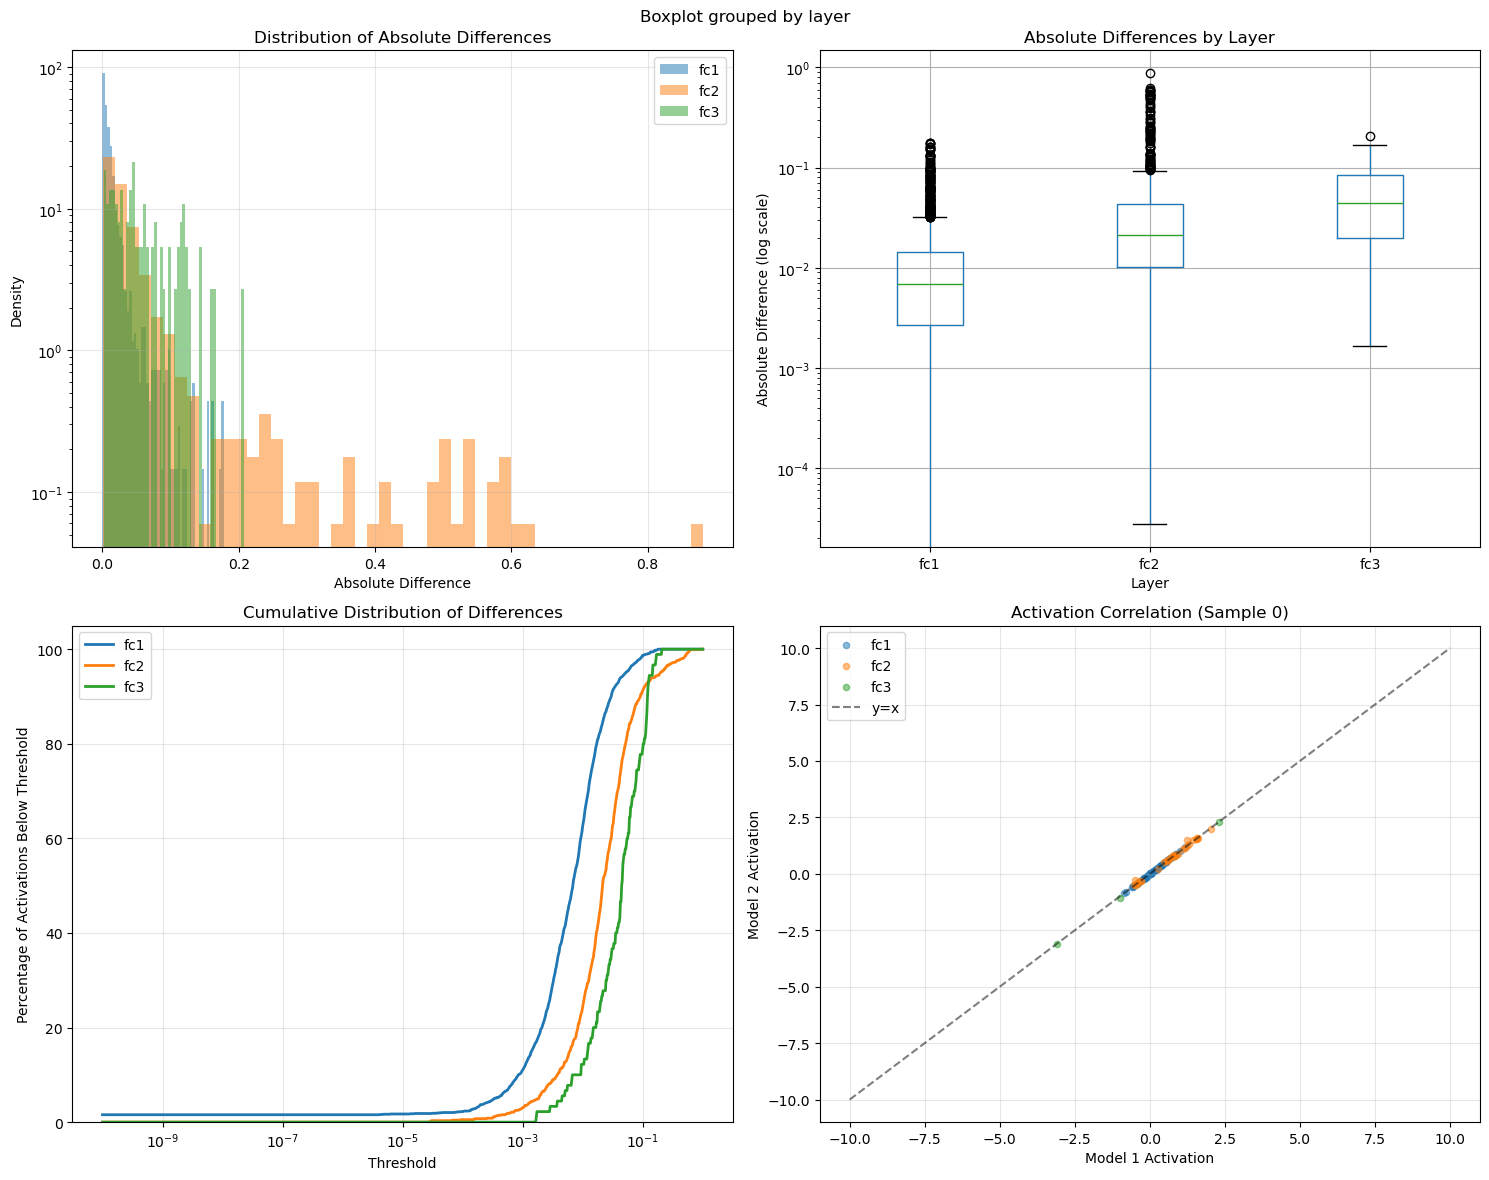

In [19]:
# Visualize distribution of differences
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Activation Differences Between Identically Initialized Models', fontsize=16)

# 1. Histogram of absolute differences by layer
ax = axes[0, 0]
for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df[diff_df['layer'] == layer]['abs_difference']
    ax.hist(layer_data, bins=50, alpha=0.5, label=layer, density=True)

ax.set_xlabel('Absolute Difference')
ax.set_ylabel('Density')
ax.set_title('Distribution of Absolute Differences')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Box plot of differences by layer
ax = axes[0, 1]
diff_df.boxplot(column='abs_difference', by='layer', ax=ax)
ax.set_yscale('log')
ax.set_title('Absolute Differences by Layer')
ax.set_xlabel('Layer')
ax.set_ylabel('Absolute Difference (log scale)')

# 3. Cumulative distribution
ax = axes[1, 0]
thresholds = np.logspace(-10, 0, 1000)

for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df[diff_df['layer'] == layer]['abs_difference'].values
    percentages = []
    
    for thresh in thresholds:
        pct = np.sum(layer_data <= thresh) / len(layer_data) * 100
        percentages.append(pct)
    
    ax.semilogx(thresholds, percentages, label=layer, linewidth=2)

ax.set_xlabel('Threshold')
ax.set_ylabel('Percentage of Activations Below Threshold')
ax.set_title('Cumulative Distribution of Differences')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

# 4. Scatter plot: Model1 vs Model2 activations
ax = axes[1, 1]
sample_data = diff_df[diff_df['sample_idx'] == 0]  # First sample

for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = sample_data[sample_data['layer'] == layer]
    ax.scatter(layer_data['activation_model1'], 
              layer_data['activation_model2'], 
              alpha=0.5, label=layer, s=20)

ax.plot([-10, 10], [-10, 10], 'k--', alpha=0.5, label='y=x')
ax.set_xlabel('Model 1 Activation')
ax.set_ylabel('Model 2 Activation')
ax.set_title('Activation Correlation (Sample 0)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('identical_init_differences.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print("\nThreshold Analysis for Identically Initialized Models:")
print("="*70)

test_thresholds = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

threshold_analysis = []

for thresh in test_thresholds:
    row = {'threshold': thresh}
    
    for layer in ['fc1', 'fc2', 'fc3']:
        layer_data = diff_df[diff_df['layer'] == layer]['abs_difference'].values
        pass_rate = np.sum(layer_data <= thresh) / len(layer_data) * 100
        row[f'{layer}_pass_rate'] = pass_rate
    
    # All layers simultaneously
    all_pass = 0
    total_samples = len(diff_df['sample_idx'].unique())
    
    for sample_idx in diff_df['sample_idx'].unique():
        sample_data = diff_df[diff_df['sample_idx'] == sample_idx]
        
        # Check if ALL neurons in ALL layers pass for this sample
        max_diff_per_layer = sample_data.groupby('layer')['abs_difference'].max()
        if all(max_diff_per_layer <= thresh):
            all_pass += 1
    
    row['all_layers_pass_rate'] = (all_pass / total_samples) * 100
    threshold_analysis.append(row)

threshold_df = pd.DataFrame(threshold_analysis)
print(threshold_df.to_string(index=False))


Threshold Analysis for Identically Initialized Models:
   threshold  fc1_pass_rate  fc2_pass_rate  fc3_pass_rate  all_layers_pass_rate
1.000000e-08       1.562500       0.000000       0.000000                   0.0
1.000000e-07       1.562500       0.000000       0.000000                   0.0
1.000000e-06       1.562500       0.000000       0.000000                   0.0
1.000000e-05       1.718750       0.000000       0.000000                   0.0
1.000000e-04       2.239583       0.520833       0.000000                   0.0
1.000000e-03      11.041667       3.020833       0.000000                   0.0
1.000000e-02      62.708333      24.270833      12.222222                   0.0
1.000000e-01      98.697917      91.250000      78.888889                   0.0



Practical Threshold Determination:
Global minimum difference: 0.00e+00
Global maximum difference: 8.81e-01

Thresholds for different confidence levels:
  90% of differences are below: 5.54e-02
  95% of differences are below: 9.28e-02
  99% of differences are below: 2.85e-01
  99.9% of differences are below: 5.98e-01

Neurons with most consistent activations (lowest max difference):

fc1 - Top 5 most consistent neurons:
                 min      mean       max       std
neuron_idx                                        
1           0.000000  0.000000  0.000000  0.000000
25          0.000031  0.001264  0.002777  0.000693
47          0.000175  0.001341  0.002964  0.000790
33          0.000231  0.001296  0.003039  0.000779
12          0.001635  0.002881  0.003815  0.000494

fc2 - Top 5 most consistent neurons:
                 min      mean       max       std
neuron_idx                                        
4           0.000153  0.005826  0.014171  0.004107
26          0.000092  0.0047

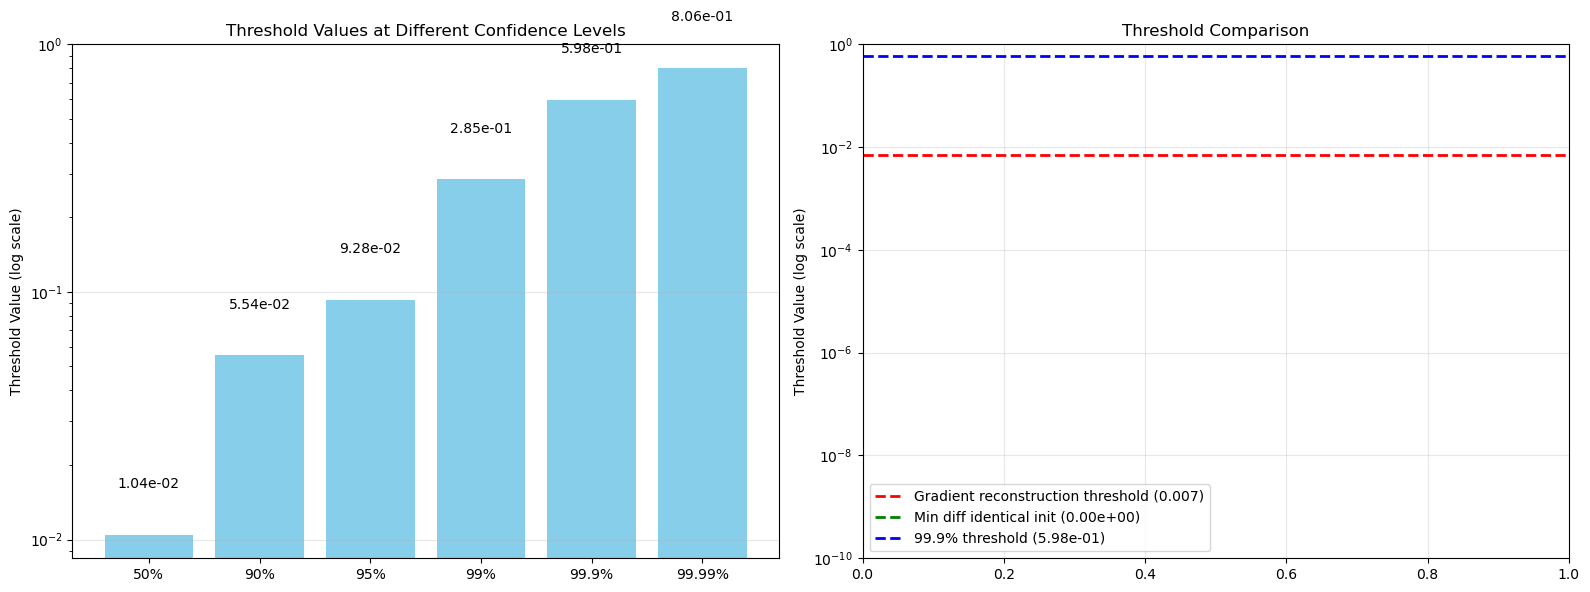


THRESHOLD RECOMMENDATION SUMMARY

Based on identical initialization analysis:
  - Minimum observed difference: 0.00e+00
  - 99.9th percentile difference: 5.98e-01
  - 99.99th percentile difference: 8.06e-01

Comparison with gradient reconstruction:
  - Gradient reconstruction threshold: 0.007
  - Ratio: 0x larger than 99.9th percentile

RECOMMENDATION:
  Use threshold of 8.06e-01 for distinguishing genuinely different activations
  This ensures 99.99% confidence that differences above this threshold are meaningful


In [21]:
# Find practical threshold
print("\nPractical Threshold Determination:")
print("="*50)

# Find minimum difference across all comparisons
global_min_diff = diff_df['abs_difference'].min()
global_max_diff = diff_df['abs_difference'].max()

print(f"Global minimum difference: {global_min_diff:.2e}")
print(f"Global maximum difference: {global_max_diff:.2e}")

# Find threshold for different confidence levels
confidence_levels = [90, 95, 99, 99.9]

print("\nThresholds for different confidence levels:")
for conf in confidence_levels:
    threshold = np.percentile(diff_df['abs_difference'], conf)
    print(f"  {conf}% of differences are below: {threshold:.2e}")

# %%
# Analyze per-neuron statistics
neuron_stats = diff_df.groupby(['layer', 'neuron_idx'])['abs_difference'].agg(['min', 'mean', 'max', 'std'])

print("\nNeurons with most consistent activations (lowest max difference):")
print("="*60)

for layer in ['fc1', 'fc2', 'fc3']:
    layer_stats = neuron_stats.loc[layer].sort_values('max')
    print(f"\n{layer} - Top 5 most consistent neurons:")
    print(layer_stats.head())

# %%
# Create final recommendation plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Show practical threshold ranges
all_diffs = diff_df['abs_difference'].values
percentiles = [50, 90, 95, 99, 99.9, 99.99]
threshold_values = [np.percentile(all_diffs, p) for p in percentiles]

bars = ax1.bar(range(len(percentiles)), threshold_values, color='skyblue')
ax1.set_xticks(range(len(percentiles)))
ax1.set_xticklabels([f'{p}%' for p in percentiles])
ax1.set_yscale('log')
ax1.set_ylabel('Threshold Value (log scale)')
ax1.set_title('Threshold Values at Different Confidence Levels')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, threshold_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height*1.5,
             f'{val:.2e}', ha='center', va='bottom', fontsize=10)

# Right: Compare with gradient-based reconstruction threshold
ax2.axhline(y=0.007, color='red', linestyle='--', linewidth=2, label='Gradient reconstruction threshold (0.007)')
ax2.axhline(y=global_min_diff, color='green', linestyle='--', linewidth=2, label=f'Min diff identical init ({global_min_diff:.2e})')
ax2.axhline(y=np.percentile(all_diffs, 99.9), color='blue', linestyle='--', linewidth=2, 
            label=f'99.9% threshold ({np.percentile(all_diffs, 99.9):.2e})')

ax2.set_ylim(1e-10, 1e0)
ax2.set_yscale('log')
ax2.set_ylabel('Threshold Value (log scale)')
ax2.set_title('Threshold Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_recommendation.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Final summary
print("\n" + "="*80)
print("THRESHOLD RECOMMENDATION SUMMARY")
print("="*80)

print("\nBased on identical initialization analysis:")
print(f"  - Minimum observed difference: {global_min_diff:.2e}")
print(f"  - 99.9th percentile difference: {np.percentile(all_diffs, 99.9):.2e}")
print(f"  - 99.99th percentile difference: {np.percentile(all_diffs, 99.99):.2e}")

print("\nComparison with gradient reconstruction:")
print(f"  - Gradient reconstruction threshold: 0.007")
print(f"  - Ratio: {0.007 / np.percentile(all_diffs, 99.9):.0f}x larger than 99.9th percentile")

print("\nRECOMMENDATION:")
practical_threshold = np.percentile(all_diffs, 99.99)
print(f"  Use threshold of {practical_threshold:.2e} for distinguishing genuinely different activations")
print(f"  This ensures 99.99% confidence that differences above this threshold are meaningful")